In [1]:
import psycopg2
import psycopg2.extras
import altair
import numpy as np
import pandas as pd
import tabulate

In [2]:
conn = psycopg2.connect('host=127.0.0.1 dbname=postgres user=postgres password=atreehasmanyleafs')

In [3]:
conn.rollback()

In [4]:
print('info of the latest run')
with conn.cursor() as cur:
    cur.execute('''
      select run_id, time_started, time_stopped
      from run
      order by time_started desc''')
    runs = cur.fetchall()

    run_id = runs[0][0]

    cur.execute('''
      select count(distinct species_sn)
      from population
      where run_id = %s
      ''', (run_id,))
    [(num_species,)] = cur.fetchall()
    
    cur.execute('''
      select count(distinct generation_sn)
      from population
      where run_id = %s
      ''', (run_id,))
    [(num_generations,)] = cur.fetchall()
    
print(tabulate.tabulate([
    ("run_id", run_id),
    ("time start", runs[0][1]),
    ("time_stop", runs[0][2]),
    ("num generations", num_generations),
    ("num_species", num_species)]))

info of the latest run
---------------  -------------------------
run_id           20190128_095609_+0000
time start       2019-01-28 09:56:09+00:00
time_stop        2019-01-28 09:56:25+00:00
num generations  6
num_species      99
---------------  -------------------------


In [5]:
print(f'top original fitnesses of run {run_id}')
sql = '''
    select generation_sn, species_sn, genome_id, original_fitness
    from population
    where run_id = %s
    order by original_fitness desc
    limit 20'''
genomes = pd.read_sql(sql, con=conn, params=(run_id,))
genomes

top original fitnesses of run 20190128_095609_+0000


,generation_sn,species_sn,genome_id,original_fitness
0,0,0,6a41549b-9cb3-4e78-9169-565c41fa5694,6.166850
1,0,0,563cb992-9cbf-4f04-bb43-bb618cc2f503,6.150438
2,0,0,d60cc5e8-12ba-4c32-bd9c-90fbc5d943c0,6.113151
3,0,0,dc403c10-5374-446f-90ea-64801e15e05c,6.110964
4,0,0,dcdfd8f8-5cb0-4bdc-a6dd-abde7d27923c,6.055729
5,0,0,0e5604b7-8abd-4403-9f41-0a94a38787c0,5.851717
6,0,0,a1e50597-b77f-423b-9969-a614c30091cd,5.826341
7,0,0,04679d5a-ba93-434d-a662-23536d60fee3,5.778124
8,1,79,662654c2-9020-4f22-8a1d-e72eb2fa4648,5.763522
9,1,47,e331b486-dedf-41a7-b0f8-0623950a0c47,5.754827


/usr/lib/python3.7/site-packages/altair/utils/core.py:284: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


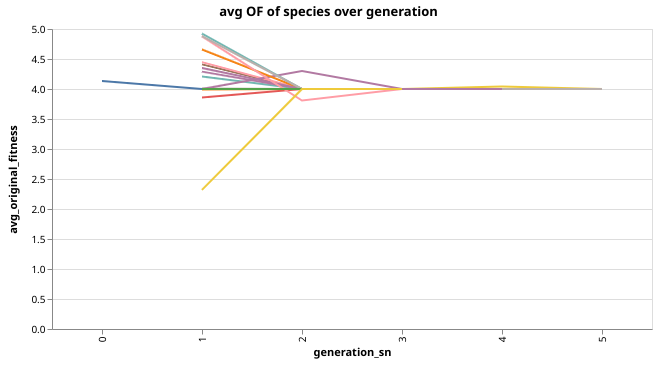

In [6]:
sql = '''
  select generation_sn, species_sn, avg(original_fitness) as avg_original_fitness
  from population
  where run_id = %s
  group by (generation_sn, species_sn)
  '''

avg_ofes = pd.read_sql(sql=sql, con=conn, params=(run_id,))
avg_ofes.head()

charts = []
for i in range(num_species):
    highlight = altair.selection(
        type='single',
        on='mouseover',
        nearest=True)
    chart = altair.Chart(
        avg_ofes.query('species_sn == @i'),
        title='avg OF of species over generation'
    ).mark_line().encode(
        x='generation_sn:N',
        y='avg_original_fitness:Q',
        color=altair.Color('species_sn:N', legend=None),
        tooltip='species_sn',
        opacity=altair.condition(highlight, altair.value(1), altair.value(0))
    ).add_selection(highlight)
    charts.append(chart)

altair.layer(*charts).properties(width=600).interactive()

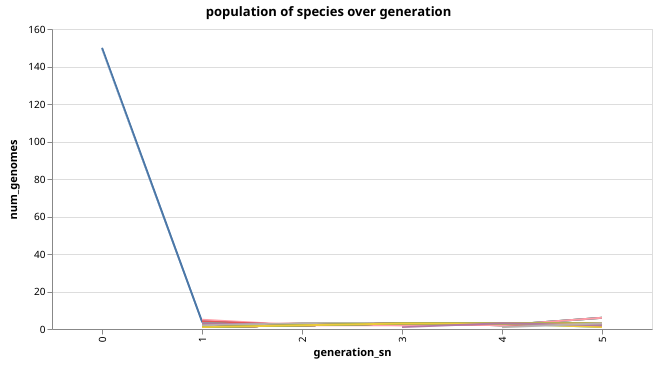

In [7]:
sql = '''
  select generation_sn, species_sn, count(1) as num_genomes
  from population
  where run_id = %s
  group by (generation_sn, species_sn)
  '''

genomes = pd.read_sql(sql=sql, con=conn, params=(run_id,))

charts = []
for i in range(num_species):
    highlight = altair.selection(
        type='single',
        on='mouseover',
        nearest=True)
    chart = altair.Chart(
        genomes.query('species_sn == @i'),
        title='population of species over generation'
    ).mark_line().encode(
        x='generation_sn:N',
        y='num_genomes:Q',
        color=altair.Color('species_sn:N', legend=None),
        tooltip='species_sn',
        opacity=altair.condition(highlight, altair.value(1), altair.value(0))
    ).add_selection(highlight)
    charts.append(chart)

altair.layer(*charts).properties(width=600).interactive()